# Data Science Quick Setup

*When you need to do some Data Science very very quickly*

## Imports and styling

In [1]:
import os
import sys
import io
from pathlib import Path
import zipfile
import datetime
import itertools
import functools
from collections import defaultdict
import cloudpickle
import sqlite3
import numpy as np
import pandas as pd
import scipy
import json
from loguru import logger

from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, TransformerMixin, clone
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLarsCV, RidgeCV, LogisticRegression, LogisticRegression
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, balanced_accuracy_score, precision_recall_curve, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample, shuffle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import skopt
import shap

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go

np.random.seed(42**3)

In [2]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


## Utility

In [ ]:
def q10(x):
    return np.quan

In [3]:
def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))
    
def _get_value_range(x):
    vals = np.array(x.dropna().unique())
    if isinstance(vals, np.object) or isinstance(vals, np.int):
        if len(vals) < 10:
            return f'{vals} ({len(vals)})'
        else:
            return f'{vals.min()} - {vals.max()} ({len(vals)})'
    else:
        return f'{vals.min()} - {vals.max()}'

def describe_df(df):
    df_nan_rate = df.isnull().sum().rename('nans') / len(df)
    df_dtype = df.dtypes
    df_values = df.apply(_get_value_range, axis=0)

    df_desription = pd.DataFrame({
        'nan_rate': df_nan_rate,
        'dtype': df_dtype,
        'values': df_values,
    }).sort_values('nan_rate')
    display(df_desription)
    
def create_data(fname, foo, **foo_kwargs):
    fpath = Path(fname)
    data = foo(**foo_kwargs)
    cloudpickle.dump(data, open(fpath, 'wb'))
    logger.info(f'data is created and dumped to {fpath}')
    return data

def get_or_create_data(fname, foo, **foo_kwargs):
    fpath = Path(fname)
    if fpath.exists():
        data = cloudpickle.load(open(fpath, 'rb'))
        logger.info(f'data is loaded from {fpath}')
    else:
        data = foo(**foo_kwargs)
        cloudpickle.dump(data, open(fpath, 'wb'))
        logger.info(f'data is created and dumped to {fpath}')
    return data

## Custom models

In [4]:
class MinMaxClipper(TransformerMixin, BaseEstimator):
    def fit(self, X, y):
        self.x_min_ = np.min(X)
        self.x_max_ = np.max(X)
        return self
        
    def transform(self, X):
        return X.clip(self.x_min_, self.x_max_, axis=1)

class FixedGAM(RegressorMixin, BaseEstimator):
    def __init__(self, df=5, degree=3, alpha=0.1):
        self.df = df
        self.degree = degree
        self.alpha = alpha
    
    def fit(self, X, y):
        X = np.array(X)
        self.x_min_ = np.min(X, axis=0)
        self.x_max_ = np.max(X, axis=0)
        self.splines_ = BSplines(X, df=[self.df] * X.shape[1], degree=[self.degree] * X.shape[1]) 
        self.estimator_ = GLMGam(y, X, smoother=self.splines_, alpha=self.alpha)
        self.res_ = self.estimator_.fit()
        return self
    
    def predict(self, X):
        X = np.clip(X, self.x_min_, self.x_max_)
        return self.res_.predict(X, exog_smooth=X)

# EDA & Visualization Examples

In [5]:
df = pd.read_csv(
    Path('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
ht(df)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaT,3.0,region_6,6,0,0,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,0,0,6,0,0,0,5.0,NaN,NaN,20.0,False,0
3996,711325,2016-10-07,2016-06-19,NaN,NaN,NaN,NaT,1.0,region_3,42,0,0,3,0,0,0,3.0,NaN,538.166579,21.0,False,0
3997,833603,2016-11-27,2016-09-30,NaN,NaN,NaN,NaT,0.0,region_3,6,0,0,0,0,0,0,1.0,NaN,535.545724,19.0,False,1


In [6]:
describe_df(df)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,nan_rate,dtype,values
loanKey,0.000000,int64,58567 - 884377 (3998)
age,0.000000,float64,18.0 - 74.0 (51)
payment_type_5,0.000000,int64,[0] (1)
payment_type_4,0.000000,int64,[0 1 3 5 7 2 4] (7)
payment_type_3,0.000000,int64,0 - 35 (24)
payment_type_2,0.000000,int64,0 - 33 (26)
payment_type_1,0.000000,int64,0 - 81 (28)
gender,0.000000,bool,[False True] (2)
TraderKey,0.000000,int64,1 - 80 (23)
payment_type_0,0.000000,int64,[ 0 2 3 1 4 15 5 6 8] (9)


In [7]:
print(f'Positive samples: {df["bad_flag"].mean():.2f}')

Positive samples: 0.10


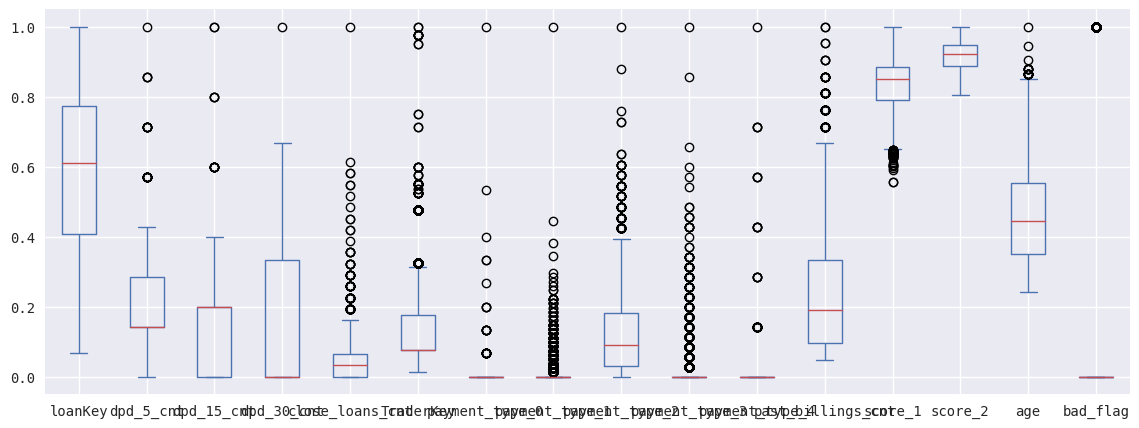

In [8]:
dft = df.select_dtypes(include=np.number).drop(columns='payment_type_5')
_ = (dft / dft.abs().max()).plot(kind='box', figsize=(14, 5))

skew 1.322
kurtosis 3.652


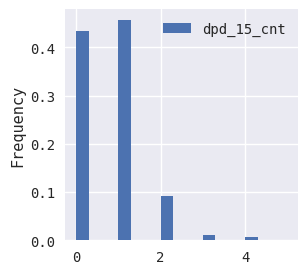

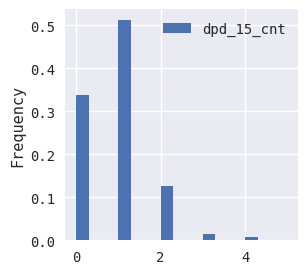

In [9]:
_ = (df.groupby('bad_flag')[['dpd_15_cnt']]
     .plot(kind='hist', bins=df['dpd_15_cnt'].dropna().unique(), density=1, width=0.3, figsize=(3, 3)))
print('skew', df['dpd_15_cnt'].skew().round(3))
print('kurtosis', df['dpd_15_cnt'].kurtosis().round(3))

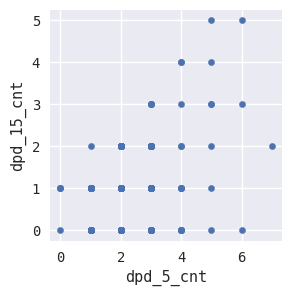

In [10]:
_ = df.plot(kind='scatter', x='dpd_5_cnt', y='dpd_15_cnt', figsize=(3, 3))

In [11]:
dft = df.select_dtypes(include=np.number).drop(columns='payment_type_5').corr()
np.fill_diagonal(dft.values, 0)
dft.abs().round(2).style.background_gradient(cmap='Blues')

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,past_billings_cnt,score_1,score_2,age,bad_flag
loanKey,0.000000,0.010000,0.100000,0.040000,0.230000,0.020000,0.010000,0.020000,0.220000,0.130000,0.020000,0.320000,0.020000,0.110000,0.050000,0.120000
dpd_5_cnt,0.010000,0.000000,0.460000,0.180000,0.150000,0.030000,0.010000,0.020000,0.160000,0.040000,0.010000,0.220000,0.060000,0.390000,0.110000,0.070000
dpd_15_cnt,0.100000,0.460000,0.000000,0.520000,0.160000,0.010000,0.010000,0.030000,0.100000,0.090000,0.020000,0.150000,0.030000,0.040000,0.000000,0.070000
dpd_30_cnt,0.040000,0.180000,0.520000,0.000000,0.070000,0.010000,0.030000,0.020000,0.040000,0.060000,0.040000,0.120000,0.160000,0.070000,0.070000,0.060000
close_loans_cnt,0.230000,0.150000,0.160000,0.070000,0.000000,0.020000,0.070000,0.220000,0.540000,0.270000,0.050000,0.730000,0.020000,0.130000,0.040000,0.070000
TraderKey,0.020000,0.030000,0.010000,0.010000,0.020000,0.000000,0.010000,0.050000,0.090000,0.080000,0.020000,0.040000,0.000000,0.000000,0.030000,0.010000
payment_type_0,0.010000,0.010000,0.010000,0.030000,0.070000,0.010000,0.000000,0.020000,0.030000,0.030000,0.000000,0.030000,0.010000,0.090000,0.010000,0.020000
payment_type_1,0.020000,0.020000,0.030000,0.020000,0.220000,0.050000,0.020000,0.000000,0.130000,0.010000,0.120000,0.240000,0.020000,0.050000,0.050000,0.010000
payment_type_2,0.220000,0.160000,0.100000,0.040000,0.540000,0.090000,0.030000,0.130000,0.000000,0.240000,0.040000,0.710000,0.040000,0.020000,0.080000,0.060000
payment_type_3,0.130000,0.040000,0.090000,0.060000,0.270000,0.080000,0.030000,0.010000,0.240000,0.000000,0.000000,0.220000,0.010000,0.000000,0.110000,0.070000


# Modelling Examples

In [12]:
# --- Objective functions ---

# --- Sklearn
# Reg: explained_variance, r2, neg_mean_absolute_error, neg_mean_squared_error, neg_root_mean_squared_error, neg_mean_squared_log_error
# Class: accuracy, balanced_accuracy, average_precision, f1, f1_weighted, neg_log_loss, precision, recall, roc_auc
# Clust: mutual_info_score

# --- LightGBM
# Reg: regression, regression_l1, huber, fair, poisson, quantile, mape
# Class: binary, multiclass, multiclassova, cross_entropy
# Rank: lambdarank, rank_xendcg

## Classification

In [13]:
df = pd.read_csv(
    Path('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
df_train, df_test = train_test_split(df, test_size=0.3)
ht(df_train)

def create_features(df):
    df2 = {
        'dpd_5_cnt': df['dpd_5_cnt'],
        'dpd_15_cnt': df['dpd_15_cnt'],
        'payment_type_1': df['payment_type_1'],
        'payment_type_2': df['payment_type_2'],
        'age': df['age'],
        'gender': df['gender'].astype('int'),    
        'rep_loan_date_diff':(df['rep_loan_date']-df['first_loan']).dt.days,
        'first_overdue_date_diff':(df['first_overdue_date']-df['first_loan']).dt.days,
    }
    return pd.DataFrame(df2)
    
X_train = create_features(df_train)
X_test = create_features(df_test)
ht(X_train)
y_train = df_train['bad_flag']
y_test = df_test['bad_flag']

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
3012,566205,2016-07-08,2016-03-13,NaN,NaN,NaN,NaT,1.0,region_4,6,0,0,3,0,0,0,3.0,518.750422,NaN,38.0,True,0
661,808498,2016-11-12,2015-08-31,NaN,NaN,NaN,NaT,2.0,region_3,6,0,0,16,0,0,0,14.0,NaN,NaN,34.0,False,0
1564,863616,2016-12-21,2016-11-06,NaN,NaN,NaN,NaT,0.0,region_0,6,0,0,1,0,0,0,1.0,611.116824,NaN,40.0,False,0
2113,452923,2016-04-21,2015-11-09,NaN,NaN,NaN,NaT,1.0,region_6,6,0,0,4,0,0,0,3.0,626.196444,NaN,60.0,False,0


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff
3012,NaN,NaN,0,3,38.0,1,117,NaN
661,NaN,NaN,0,16,34.0,0,439,NaN
1564,NaN,NaN,0,1,40.0,0,45,NaN
2113,NaN,NaN,0,4,60.0,0,164,NaN


### Logistic Regression

In [14]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = LogisticRegression(
    fit_intercept=True, 
    penalty='l2',
#     C=1.,
    class_weight=None,
    solver='liblinear',
    random_state=42
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__C': [0.1, 1., 10.],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
p_train_hat = m.predict_proba(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

display(pd.Series(np.concatenate([best.coef_[0], [best.intercept_[0]]]).round(2), 
                  index=np.concatenate([X_train.columns, ['intercept']])).to_frame().T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
LogisticRegression(random_state=42, solver='liblinear')
best cv score = -0.3154
log loss (train) = 2.2481
accuracy (train) = 0.8967
b accuracy (train) = 0.4998
b accuracy (test) = 0.4991


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff,intercept
0,0.17,0.09,0.08,0.12,-0.41,0.12,-0.6,-0.05,-2.34


### Sklearn GB Classifier

In [15]:
transformer1 = SimpleImputer(fill_value=-1)
transformer2 = OneHotEncoder(handle_unknown='ignore')

estimator = GradientBoostingClassifier(
    n_estimators=100, 
    min_samples_leaf=10,
    loss='log_loss',
    subsample=1,
    random_state=42,
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__max_leaf_nodes': [15, 7, 3],
        'e__learning_rate': [0.001, 0.01, 0.1],
#         'subsample': [1., 0.7],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train, e__sample_weight=None)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
p_train_hat = m.predict_proba(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

# explainer = shap.TreeExplainer(m.best_estimator_, data=X_train_)
# shap_values = explainer.shap_values(X_test_)
# shap.summary_plot(shap_values, X_test_.sample(frac=.5))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GradientBoostingClassifier(max_leaf_nodes=3, min_samples_leaf=10,
                           random_state=42, subsample=1)
best cv score = -0.3156
log loss (train) = 2.2182
accuracy (train) = 0.8985
b accuracy (train) = 0.5085
b accuracy (test) = 0.4986


### LightGBM Classifier

Fitting 5 folds for each of 36 candidates, totalling 180 fits
LGBMClassifier(is_unbalance=False, min_child_samples=10, num_leaves=3,
               objective='cross_entropy', reg_lambda=1.0)
best cv score = -0.3026
log loss (train) = 2.3762
accuracy (train) = 0.8996
b accuracy (train) = 0.5183
b accuracy (test) = 0.5080


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


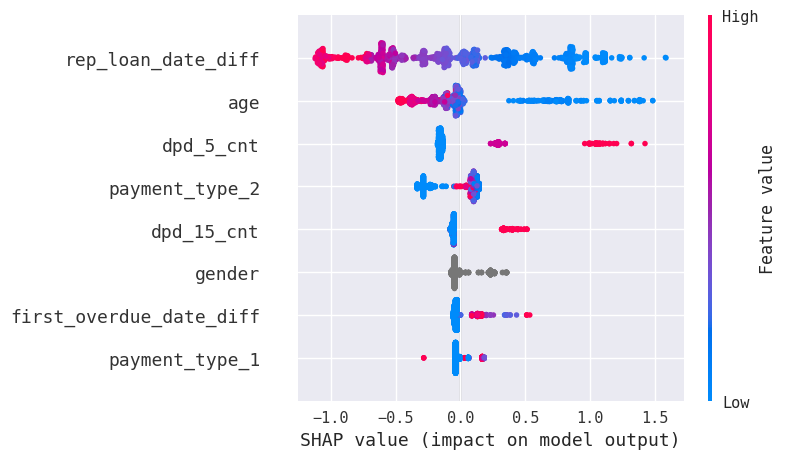

In [16]:
X_train_ = X_train.fillna(-1)
X_train_['gender'] = X_train_['gender'].astype('category')
X_test_ = X_test.fillna(-1)
X_test_['gender'] = X_test_['gender'].astype('category')

estimator = lgb.LGBMClassifier(
    n_estimators=100, 
    min_child_samples=10,
    objective='cross_entropy',
    is_unbalance=False,
#     bagging_freq=1,
#     bagging_fraction=0.5,
#     monotone_constraints=(1, 1, 1, 1, 1, 1, 1, 1, -1, 0),
)

m = GridSearchCV(
    estimator,
    {
#         'is_unbalance': [True, False],
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.001, 0.01, 0.1],
        'reg_lambda': [0, 0.01, 0.1, 1.],
#         'bagging_freq': [0, 1],
#         'bagging_fraction': [0.3],
    },
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train_, y_train)

best = m.best_estimator_
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)
y_test_hat = m.predict(X_test_)
                              
print(f'log loss (train) = {log_loss(y_train, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test, y_test_hat):.4f}')

explainer = shap.TreeExplainer(best, X_train.sample(frac=0.3))
shap_values = explainer.shap_values(X_test_, y_test)
shap.summary_plot(shap_values, X_test_)

### Tabnet Classifier

In [17]:
m = TabNetClassifier()
imputer = KNNImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_0, X_train_1 = train_test_split(X_train_imputed, test_size=0.3, shuffle=False)
y_train_0, y_train_1 = train_test_split(y_train, test_size=0.3, shuffle=False)

_ = m.fit(X_train_0, y_train_0.values, eval_set=[(X_train_1, y_train_1.values)])

y_train_hat = m.predict(X_train_imputed)
p_train_hat = m.predict_proba(X_train_imputed)
y_test_hat = m.predict(X_test_imputed)
                              
print(f'log loss (train) = {log_loss(y_train.values, p_train_hat[:, 0]):.4f}')
print(f'accuracy (train) = {accuracy_score(y_train.values, y_train_hat):.4f}')
print(f'b accuracy (train) = {balanced_accuracy_score(y_train.values, y_train_hat):.4f}')
print(f'b accuracy (test) = {balanced_accuracy_score(y_test.values, y_test_hat):.4f}')

Device used : cuda


epoch 0  | loss: 0.54376 | val_0_auc: 0.55098 |  0:00:00s
epoch 1  | loss: 0.42807 | val_0_auc: 0.56649 |  0:00:00s
epoch 2  | loss: 0.39245 | val_0_auc: 0.54068 |  0:00:00s
epoch 3  | loss: 0.36404 | val_0_auc: 0.50069 |  0:00:00s
epoch 4  | loss: 0.33905 | val_0_auc: 0.47627 |  0:00:00s
epoch 5  | loss: 0.33482 | val_0_auc: 0.55172 |  0:00:00s
epoch 6  | loss: 0.36896 | val_0_auc: 0.60097 |  0:00:00s
epoch 7  | loss: 0.31969 | val_0_auc: 0.60863 |  0:00:00s
epoch 8  | loss: 0.32532 | val_0_auc: 0.5963  |  0:00:00s
epoch 9  | loss: 0.33951 | val_0_auc: 0.65903 |  0:00:00s
epoch 10 | loss: 0.30966 | val_0_auc: 0.65332 |  0:00:00s
epoch 11 | loss: 0.31219 | val_0_auc: 0.65452 |  0:00:00s
epoch 12 | loss: 0.29572 | val_0_auc: 0.64524 |  0:00:00s
epoch 13 | loss: 0.31063 | val_0_auc: 0.64097 |  0:00:00s
epoch 14 | loss: 0.3314  | val_0_auc: 0.63639 |  0:00:00s
epoch 15 | loss: 0.28015 | val_0_auc: 0.62444 |  0:00:00s
epoch 16 | loss: 0.30285 | val_0_auc: 0.601   |  0:00:01s
epoch 17 | los

Best weights from best epoch are automatically used!
divide by zero encountered in log
invalid value encountered in multiply


## Regression

In [18]:
df = pd.read_csv(
    Path('data', 'dummy_loans.csv'), 
    parse_dates=['rep_loan_date', 'first_loan', 'first_overdue_date'],
)
df_train, df_test = train_test_split(df, test_size=0.3)
ht(df_train)

def create_features(df):
    df2 = {
        'dpd_5_cnt': df['dpd_5_cnt'],
        'dpd_15_cnt': df['dpd_15_cnt'],
        'payment_type_1': df['payment_type_1'],
        'payment_type_2': df['payment_type_2'],
        'age': df['age'],
        'gender': df['gender'].astype('int'),    
        'rep_loan_date_diff':(df['rep_loan_date']-df['first_loan']).dt.days,
        'first_overdue_date_diff':(df['first_overdue_date']-df['first_loan']).dt.days,
    }
    return pd.DataFrame(df2)
    
X_train = create_features(df_train)
X_test = create_features(df_test)
ht(X_train)
y_train = df_train['bad_flag']
y_test = df_test['bad_flag']

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
183,561583,2016-07-04,2015-12-30,1.0,1.0,0.0,2016-04-01,1.0,region_4,6,0,0,6,0,0,0,6.0,411.303183,NaN,34.0,True,1
868,492853,2016-05-16,2016-04-21,NaN,NaN,NaN,NaT,0.0,region_6,7,0,0,1,0,0,0,NaN,566.687983,NaN,28.0,False,0
76,781748,2016-10-31,2016-08-02,1.0,1.0,0.0,2016-10-07,0.0,region_4,57,0,0,2,0,0,0,2.0,NaN,529.213889,19.0,False,0
3891,346897,2016-02-17,2016-01-17,NaN,NaN,NaN,NaT,0.0,region_2,12,0,0,1,0,0,0,1.0,441.496424,NaN,30.0,True,1


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff
183,1.0,1.0,0,6,34.0,1,187,93.0
868,NaN,NaN,0,1,28.0,0,25,NaN
76,1.0,1.0,0,2,19.0,0,90,66.0
3891,NaN,NaN,0,1,30.0,1,31,NaN


### LinearRegression (ElasticNet)

In [19]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = ElasticNet(
    fit_intercept=True, 
    l1_ratio=.5,
#     alpha=1.,
    random_state=42
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__alpha': [0.1, 1., 10.],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

best = m.best_estimator_.steps[-1][-1]
print(best)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

display(pd.Series(np.concatenate([best.coef_, [best.intercept_]]).round(3), 
                  index=np.concatenate([X_train.columns, ['intercept']])).to_frame().T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
ElasticNet(alpha=0.1, random_state=42)
best cv score = -0.0875
MSE (train) = 0.0875
MAE (train) = 0.1749
r2 (train) = 0.0000
r2 (test) = -0.0012


,dpd_5_cnt,dpd_15_cnt,payment_type_1,payment_type_2,age,gender,rep_loan_date_diff,first_overdue_date_diff,intercept
0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.097


### GAM

In [20]:
transformer1 = SimpleImputer(strategy='mean')
transformer2 = StandardScaler()

estimator = FixedGAM(
    df=5,
    degree=3, 
#     alpha=0.1,
)

m = GridSearchCV(
    Pipeline((
        ('t1', transformer1),
        ('t2', transformer2),
        ('e', estimator),
    )),
    {
        'e__alpha': [0.1, 1., 10.],
#         'e__df': [5, 10],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

print(m.best_estimator_.steps[-1][-1])
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
FixedGAM(alpha=1.0)
best cv score = -0.0816
MSE (train) = 0.0795
MAE (train) = 0.1627
r2 (train) = 0.0914
r2 (test) = 0.0715


### LightGBM

In [21]:
estimator = lgb.LGBMRegressor(
    n_estimators=100, 
    min_child_samples=10,
    objective='huber',
#     bagging_freq=1,
#     bagging_fraction=0.5,
)

m = GridSearchCV(
    estimator,
    {
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'reg_lambda': [0, 0.01, 0.1, 1.],
#         'bagging_freq': [0, 1],
#         'bagging_fraction': [0.3],
    },
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

_ = m.fit(X_train, y_train)

print(m.best_estimator_)
print(f'best cv score = {m.best_score_:.4f}')

y_train_hat = m.predict(X_train)
y_test_hat = m.predict(X_test)
                              
print(f'MSE (train) = {mean_squared_error(y_train, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test, y_test_hat):.4f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
LGBMRegressor(min_child_samples=10, num_leaves=3, objective='huber',
              reg_lambda=0.1)
best cv score = -0.0820
MSE (train) = 0.0750
MAE (train) = 0.1538
r2 (train) = 0.1424
r2 (test) = 0.0598


### Tabnet Regressor

In [22]:
m = TabNetRegressor()
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_0, X_train_1 = train_test_split(X_train_imputed, test_size=0.3, shuffle=False)
y_train_0, y_train_1 = train_test_split(y_train, test_size=0.3, shuffle=False)

_ = m.fit(
    X_train_0, y_train_0.values.reshape(-1, 1), 
    eval_set=[(X_train_1, y_train_1.values.reshape(-1, 1))]
)

y_train_hat = m.predict(X_train_imputed)
y_test_hat = m.predict(X_test_imputed)
                              
print(f'MSE (train) = {mean_squared_error(y_train.values, y_train_hat):.4f}')
print(f'MAE (train) = {mean_absolute_error(y_train.values, y_train_hat):.4f}')
print(f'r2 (train) = {r2_score(y_train.values, y_train_hat):.4f}')
print(f'r2 (test) = {r2_score(y_test.values, y_test_hat):.4f}')

epoch 0  | loss: 1.88344 | val_0_mse: 558.19519|  0:00:00s
epoch 1  | loss: 1.4787  | val_0_mse: 106.20329|  0:00:00s
epoch 2  | loss: 0.67185 | val_0_mse: 68.36578|  0:00:00s


Device used : cuda


epoch 3  | loss: 0.91033 | val_0_mse: 42.95406|  0:00:00s
epoch 4  | loss: 0.56424 | val_0_mse: 29.36429|  0:00:00s
epoch 5  | loss: 0.3846  | val_0_mse: 20.70762|  0:00:00s
epoch 6  | loss: 0.3624  | val_0_mse: 25.96918|  0:00:00s
epoch 7  | loss: 0.26634 | val_0_mse: 19.99397|  0:00:00s
epoch 8  | loss: 0.2032  | val_0_mse: 19.82372|  0:00:00s
epoch 9  | loss: 0.20116 | val_0_mse: 17.61187|  0:00:00s
epoch 10 | loss: 0.20227 | val_0_mse: 14.22962|  0:00:00s
epoch 11 | loss: 0.20255 | val_0_mse: 13.43072|  0:00:00s
epoch 12 | loss: 0.17291 | val_0_mse: 6.91265 |  0:00:00s
epoch 13 | loss: 0.13559 | val_0_mse: 3.73645 |  0:00:00s
epoch 14 | loss: 0.12606 | val_0_mse: 5.24345 |  0:00:00s
epoch 15 | loss: 0.14071 | val_0_mse: 5.10143 |  0:00:00s
epoch 16 | loss: 0.13812 | val_0_mse: 3.88734 |  0:00:00s
epoch 17 | loss: 0.11314 | val_0_mse: 3.01231 |  0:00:00s
epoch 18 | loss: 0.11407 | val_0_mse: 2.05305 |  0:00:01s
epoch 19 | loss: 0.10135 | val_0_mse: 1.38653 |  0:00:01s
epoch 20 | los

Best weights from best epoch are automatically used!


# SQL Examples

In [23]:
evil_records = pd.read_csv(Path('data', 'evil_data.csv'))
display(evil_records)

db_path = Path('db', 'main.db')
db_path.parent.mkdir(exist_ok=True)

with sqlite3.connect(db_path) as conn:
    c = conn.cursor()
    try:
        c.execute("""DROP TABLE EVIL_INVADERS""")
    except:
        print('Warning: The table does not exist')
    
with sqlite3.connect(db_path) as conn:
    c = conn.cursor()

    c.execute("""\
        CREATE TABLE EVIL_INVADERS (
           ID TEXT PRIMARY KEY,
           AGE INTEGER,
           POWER_LVL FLOAT
        )
        """
    )
    
with sqlite3.connect(db_path) as conn:
    try:
        c = conn.cursor()
        c.executemany(
            """INSERT INTO EVIL_INVADERS VALUES (?,?,?)""",
            evil_records.values.tolist()
        )
    except:
        conn.rollback()
        raise
    else:
        conn.commit()

with sqlite3.connect(db_path) as conn:
    c = conn.cursor()
    evil_records_db = c.execute(
        """SELECT * FROM EVIL_INVADERS WHERE POWER_LVL > ?""",
        [0]
    ).fetchall()
    columns = [x[0] for x in c.description]
    evil_records_db = pd.DataFrame(evil_records_db, columns=columns)
display(evil_records_db)

,id,age,power_lvl
0,Shrimp,45,1.20
1,Alaska Doom,17,1.04
2,Minni Manny,23,16.50


,ID,AGE,POWER_LVL
0,Shrimp,45,1.20
1,Alaska Doom,17,1.04
2,Minni Manny,23,16.50


# Statistics Examples

## Basic statistics

In [24]:
a = np.random.normal(0, 1, size=50)
b = a + np.random.normal(0, 1.5, size=50)

print(f'a mean = {np.sum(a) / len(a):.2f} | {np.mean(a):.2f}')
print(f'a var = {np.sum((a - np.mean(a)) ** 2) / (len(a)-1):.2f} | {np.var(a, ddof=1):.2f} | {np.var(a, ddof=1):.2f}')
print(f'a skew = {np.mean((a - np.mean(a)) ** 3) / np.std(a) ** 3:.2f} | {scipy.stats.skew(a):.2f}')
print(f'a b covar = {np.cov(a, b, ddof=1)[0, 1]:.2f}')
print(f'a b corr = {np.corrcoef(a, b)[0, 1]:.2f}')
print(f'a b corr = {np.corrcoef(a, b)[0, 1]:.2f}')
print(f'a b kendall = {scipy.stats.kendalltau(a, b)[0]:.2f}')
print(f'a b spearman = {scipy.stats.spearmanr(a, b)[0]:.2f}')

a mean = 0.08 | 0.08
a var = 1.08 | 1.08 | 1.08
a skew = 0.03 | 0.03
a b covar = 1.26
a b corr = 0.63
a b corr = 0.63
a b kendall = 0.46
a b spearman = 0.62


## Sample descriptive statistics

In [25]:
df = pd.DataFrame({
    'a': np.arange(20),
    'b': np.arange(20),
    'c': np.linspace(0, 1, 20) ** 2,
})
df['d'] = df['a'] + df['b'] + df['c'] * 5 + np.random.normal(0, 1., size=20)

# - aggregate stats
ht(df)
display(df.agg(['mean', 'median', 'var', 'std'], axis=0))

# - correlation and collinearity
corr_mtx = df[['a', 'b', 'c']].corr()
display(corr_mtx.round(2))
for i in range(0, corr_mtx.shape[0]):
    for j in range(i+1, corr_mtx.shape[0]):
        if corr_mtx.iloc[i, j] > 0.99:
            print('collinear columns:', df.columns[i], df.columns[j], corr_mtx.iloc[i, j])
df = df.drop(columns='b')

# - outliers
ss = np.random.standard_t(2, size=100)
display(df.loc[np.abs(scipy.stats.zscore(df['a'])) > 2])

,a,b,c,d
0,0,0,0.000000,0.267984
1,1,1,0.002770,1.794261
18,18,18,0.897507,40.397986
19,19,19,1.000000,43.092938


,a,b,c,d
mean,9.50000,9.50000,0.342105,20.625816
median,9.50000,9.50000,0.250693,20.481827
var,35.00000,35.00000,0.104043,187.326137
std,5.91608,5.91608,0.322557,13.686714


,a,b,c
a,1.00,1.00,0.97
b,1.00,1.00,0.97
c,0.97,0.97,1.00


collinear columns: a b 1.0


,a,c,d


## Scipy distributions

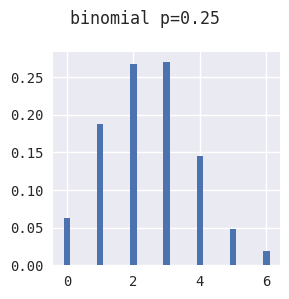

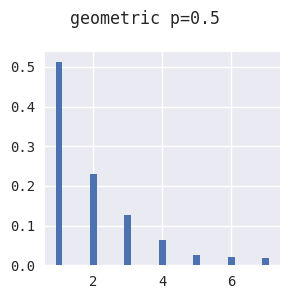

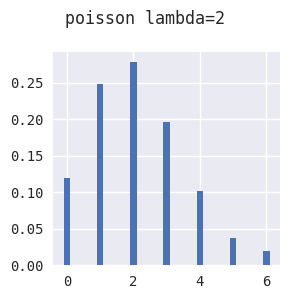

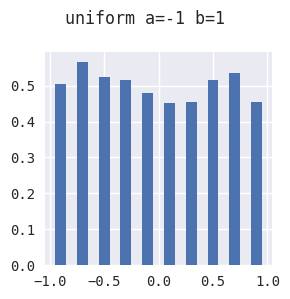

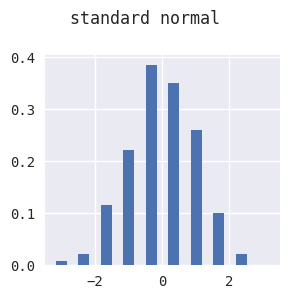

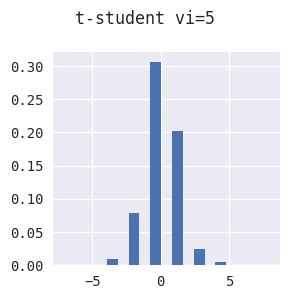

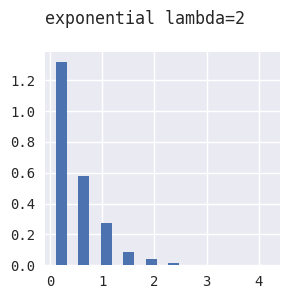

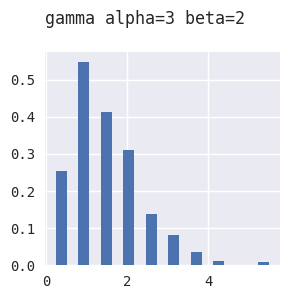

In [26]:
# binomial: E(X) = p*n, Var(X) = p*(1-p)*n
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.binom(n=10, p=0.25).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
_ = plt.suptitle('binomial p=0.25')

# geometric: E(X) = 1/p, Var(X) = (1-p) / p^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.geom(p=0.5).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
plt.suptitle('geometric p=0.5')

# poisson: E(X) = lambda, Var(X) = lambda
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.poisson(mu=2).rvs(size=1000)
plt.hist(a, bins=np.unique(a), density=1, rwidth=0.2, align='left')
plt.suptitle('poisson lambda=2')

# -----

# uniform: E(X) = (a+b)/2, Var(X)=a*b/12
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.uniform(loc=-1, scale=2).rvs(size=1000)
# print(a.sta)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('uniform a=-1 b=1')

# normal: E(X) = mu, Var(X) = sigma^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.norm(loc=0, scale=1).rvs(size=1000)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('standard normal')

# t-student: E(X) = mu, Var(X) = vi/(vi-2) * sigma^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.t(df=5, loc=0, scale=1).rvs(size=1000)
plt.hist(a, density=1, rwidth=0.5, align='mid')
plt.suptitle('t-student vi=5')

# exponential: E(X) = 1/lambda, Var(X) = 1/lambda^2
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.expon(scale=1/2).rvs(size=1000)
plt.hist(a, bins=10, density=1, rwidth=0.5, align='mid')
plt.suptitle('exponential lambda=2')

# gamma: E(X) = alpha/beta, Var(X) = alpha/beta^2
# alpha = 1 -> exponential
plt.figure(figsize=(3,3), tight_layout=True)
a = scipy.stats.gamma(a=3, scale=1/2).rvs(size=1000)
plt.hist(a, bins=10, density=1, rwidth=0.5, align='mid')
_ = plt.suptitle('gamma alpha=3 beta=2')

## Confidence intervals

In [27]:
# - estimation of p for binomial distribution
n = 30
tails = 10
p = tails / n
sigma = np.sqrt(p * (1-p) / (n - 1))

# - approximate at normal (using CDF inverse)
print(f'conf interval = {scipy.stats.norm.ppf([0.025, 0.975], loc=p, scale=sigma)}')

# - approximate at normal (using CDF)
c1 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.025, x0=p, x1=p-0.01, method='secant')
c2 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.975, x0=p, x1=p+0.01, method='secant')
print(f'conf interval = {[c1.root, c2.root]}')

# - using MC simulations
N = 1000000
# arr = np.random.binomial(p=p, n=n, size=N)
p_samples = scipy.stats.binom.rvs(p=p, n=n, size=N) / n
p_samples = np.sort(p_samples)
c1 = p_samples[int(N*0.025)]
c2 = p_samples[int(N*0.975)]
print(f'conf interval = {[c1, c2]}')

conf interval = [0.16176275 0.50490392]
conf interval = [0.16176274710435318, 0.5049039195623135]
conf interval = [0.16666666666666666, 0.5]


## Equal sample mean test

t-test pval for equal means = 0.160
MC simulation proba for mean diff less than 0.1 = 0.487


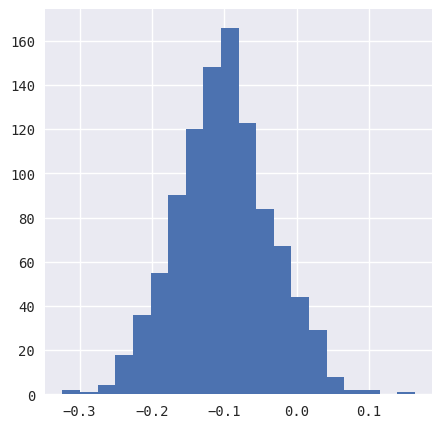

In [28]:
a = np.random.normal(0, 1, size=1000)
b = np.random.normal(0, 2, size=1000)

tstat, tpval = scipy.stats.ttest_ind(a, b, equal_var=False)
print(f't-test pval for equal means = {tpval:.3f}')

n = 1000
a_b_mean_diff = []
for i in range(n):
    a_mean = np.mean(np.random.choice(a, size=len(a), replace=True))
    b_mean = np.mean(np.random.choice(b, size=len(b), replace=True))
    a_b_mean_diff.append(a_mean-b_mean)
a_b_mean_diff = np.array(sorted(a_b_mean_diff))
_ = plt.hist(a_b_mean_diff, bins=20)
ci = 0.1
print(f'MC simulation proba for mean diff less than {ci} = {np.mean(np.abs(a_b_mean_diff) < ci)}')

## MLE vs. Method of Moments

- estimate lambda fitting both loc and scale
loc = 0.00
lambda = 1.99

- estimate lambda via MLE
lambda = 1.99

- estimate lambda via method of moments
lambda = 1.99


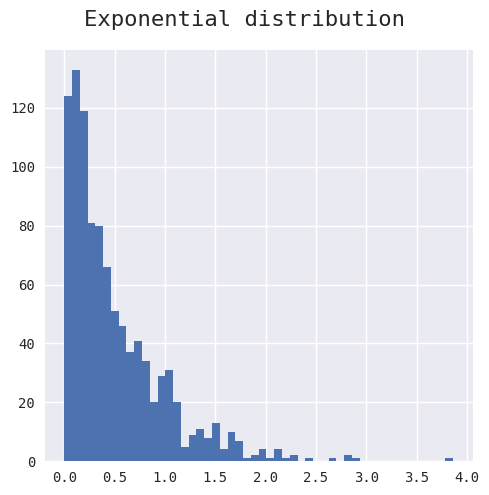

In [29]:
# - estimate 
a = scipy.stats.expon.rvs(scale=1/2, size=1000)
_ = plt.hist(a, bins=50)
plt.suptitle('Exponential distribution', fontsize=16)
plt.tight_layout()

loc_scale_fit = scipy.stats.expon.fit(a)
print('- estimate lambda fitting both loc and scale')
print(f'loc = {loc_scale_fit[0]:.2f}')
print(f'lambda = {1. / loc_scale_fit[1]:.2f}')

lambda_fit = scipy.optimize.minimize(lambda x: -np.mean(scipy.stats.expon.logpdf(a, scale=1./x)), x0=1., bounds=[(0, None)])
print()
print('- estimate lambda via MLE')
print(f'lambda = {lambda_fit.x[0]:.2f}')

print()
print('- estimate lambda via method of moments')
print(f'lambda = {1. / np.mean(a):.2f}')

## Linear Regression Estimator

In [30]:
class CustomLR(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # y = X*b + e
        # (y - X*b) ^ 2 -> min  =>  -2*X_T * (y - X*b) = 0  =>  X_T*y = X_T*X*b  =>  b = (X_T*X)^(-1) * X_T * y
        X = np.array(X)
        y = np.array(y)
        assert len(X.shape) == 2
        assert len(y.shape) == 1
        self.coef_ = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
#         self.coef_ = scipy.linalg.lstsq(X, y)[0]
        return self
        
    def predict(self, X):
        X = np.array(X)
        assert len(X.shape) == 2
        return np.dot(X, self.coef_)
    
    
X = np.random.normal(size=(100, 3))
y = X[:, 0] + 2*X[:, 1] - 2*X[:, 2] + np.random.normal(scale=0.1, size=100)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_.round(3))
print(mean_squared_error(y, y_hat).round(4))

[ 1.01   1.989 -2.019]
0.0097


## Linear Regression Statistics

In [31]:
# --- all statistics via statsmodels OLS
df = pd.DataFrame({
    'x1': np.arange(20),
    'x2': np.linspace(0, 1, 20) ** 2,
})
df['y'] = df['x1'] * 2 + df['x2'] * 5 + np.random.normal(0, 1., size=20)

X = df.drop(columns='y')
y = df['y']
mres = sm.OLS(y, exog=X).fit()
# print(mres.params)
display(mres.summary())

# --- all statistics manually
m = LinearRegression(fit_intercept=False)
m.fit(X, y)
print()
display(pd.Series(m.coef_, index=X.columns).rename('coeffients').to_frame().T.round(3))

y_hat = m.predict(X)
y_ = np.array(y)

# - R2
print(f'r2 = {1 - np.var(y_-y_hat)/np.var(y_):.3f}')

# - noise variance estimate
sigma2 = np.var(y_-y_hat, ddof=1+X.shape[1])
print(f'sigma2 estimate = {sigma2:.3f}')

# - T-scores & p-values
coef = m.coef_
coef_std = np.sqrt(sigma2 * np.diag(np.linalg.inv(np.dot(X.T, X))))
coef_tscore = coef / coef_std
print(f'T-scores = {coef_tscore.round(3)}')
coef_pval = 2 * scipy.stats.t(df=20-X.shape[1]-1).sf(coef_tscore)
print(f'P-values = {coef_pval.round(5)}')

# - confidence intervals
c1_01 = scipy.stats.t(df=20-X.shape[1]-1).ppf(0.025)
c2_01 = scipy.stats.t(df=20-X.shape[1]-1).ppf(0.975)
coef_c1 = coef + c1_01 * coef_std
coef_c2 = coef + c2_01 * coef_std
print(f'95% confidence intervals:')
print(np.vstack([coef_c1, coef_c2]).T.round(3))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5979.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):                    3.91e-26
Time:                        14:30:19   Log-Likelihood:                         -27.353
No. Observations:                  20   AIC:                                      58.71
Df Residuals:                      18   BIC:                                      60.70
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9598      0.081     24.276      0.000       1.790       2.129
x2             5.9928      1.931      3.104      0.006       1.936      10.049
==============================================================================
Omnibus:                        3.346   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                1.371
Skew:                           0.182   Prob(JB):                        0.504
Kurtosis:                       1.770   Cond. No.                         96.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,x1,x2
coeffients,1.96,5.993


r2 = 0.995
sigma2 estimate = 1.062
T-scores = [23.592  3.016]
P-values = [0.      0.00778]
95% confidence intervals:
[[ 1.785  2.135]
 [ 1.801 10.185]]


## Logistic Regression Estimator

In [32]:
def deviance(b, X, y, c):
    p1 = 1 / (1+np.exp(-X @ b))
    loglik = y @ np.log(p1) + (1-y) @ np.log(1-p1)
    return -2*loglik + c * np.sum(np.abs(b))

class CustomLR(RegressorMixin, BaseEstimator):
    """
    log p_i/(1-p_i) = b*x_i <=> p_i = 1 / 1+exp(-b*x_i)
                                1-p_i = 1 / 1+exp(b*x_i)

    loglikelihood(b) = sum_i log(y_i*p_i + (1-y_i)*(1-p_i))
                     = sum_i log(y_i / 1+exp(-b*x_i) + (1-y_i) / 1+exp(b*x_i))
    """
    def __init__(self, c=0.1):
        self.c = c
    
    def fit(self, X, y):
        self.res_ = scipy.optimize.minimize(deviance, x0=np.zeros(X.shape[1]), args=(X, y, self.c))
        self.coef_ = self.res_.x
        return self
    
    def predict_proba(self, X):
        return 1 / (1+np.exp(-X @ self.coef_))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)
    
    
X = np.random.normal(0, 1, size=(100, 2))
y = (np.sum(X, axis=1) + np.random.normal(0, 0.5, size=100) > 0).astype(int)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_)
print(accuracy_score(y, y_hat))

[2.97780561 4.03034395]
0.89


# Numerical Examples

## Integration

In [33]:
print(scipy.integrate.quad(lambda x: x**2, 0, 1)[0])
print(scipy.integrate.trapz([x**2 for x in np.linspace(0, 1, 50)], dx=1/50))

0.33333333333333337
0.326734693877551


## Find a minimum

In [34]:
# scipy.optimize.minimize(lambda x: x**2, x0=.5, method='BFGS', bounds=None)
scipy.optimize.minimize(lambda x: np.tan(x)**2, x0=.5, bounds=[(-1, 1)])

      fun: 9.537347071406957e-16
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.17651911e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-3.08825955e-08])

## Find a root

In [35]:
scipy.optimize.root_scalar(lambda x: x**2 - 2, x0=1, x1=1.1, method='secant')

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.4142135623730951

## Matrix inverse and decompositions

In [36]:
A = np.random.normal(size=(2, 2))
print(A)
print(scipy.linalg.inv(scipy.linalg.inv(A)))

Q, R = scipy.linalg.qr(np.random.normal(size=(2, 2)))
print()
print(Q)
print(R)

U, D, V = scipy.linalg.svd(np.random.normal(size=(2, 3)))
print()
print(U)
print(D)
print(V)

R = np.random.normal(size=(2, 2))
print()
print(R)

R_ = scipy.linalg.cholesky(np.matmul(R, R.T))
print(R_)

[[-0.76944876  0.00829939]
 [-0.28253675 -1.15593944]]
[[-0.76944876  0.00829939]
 [-0.28253675 -1.15593944]]

[[-0.48725409 -0.87326024]
 [-0.87326024  0.48725409]]
[[ 1.49927989 -0.36182202]
 [ 0.         -1.66297825]]

[[-0.69945373 -0.71467788]
 [-0.71467788  0.69945373]]
[2.34295586 1.19346553]
[[ 0.487998    0.12926018  0.86322057]
 [-0.43459797  0.89364949  0.11187134]
 [-0.75695611 -0.4297469   0.49227537]]

[[ 0.30582675  0.25702408]
 [ 2.18656565 -1.68064984]]
[[0.3994889  0.5926142 ]
 [0.         2.69341078]]


## Matrix equations

In [37]:
# A = B * x
B = np.random.normal(size=(3, 3))
x = np.random.normal(size=3)
print(x)
A = np.dot(B, x)
x_ = scipy.linalg.solve(B, A)
print(x_)
x_, rank, N, s = scipy.linalg.lstsq(B, A, cond=None)
print(x_)

[-0.99972848 -0.22450344  0.31825543]
[-0.99972848 -0.22450344  0.31825543]
[-0.99972848 -0.22450344  0.31825543]
